<h5>Importing libraries</h5>

In [149]:
#data handling
import pandas as pd
import numpy as np
import os 
from PIL import Image

# Machine learning (non deep learning)
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 

# Deep learning
import tensorflow as tf
import keras
from keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# misc
import time # for recording model training time

<h5>Read in images into numpy arrays and record type of tumor with one hot encoder and reshaping data and split between test and train data</h5>

In [150]:
img_reshape_size = (32,32)

binary_data = []
binary_result = []

binary_encoder = OneHotEncoder()
binary_encoder.fit([[0], [1]]) 

# path to tumor files
tumor_image_dir = "dataset/split_data/binary/tumor"
tumor_files = os.listdir(tumor_image_dir)

# path to non tumor files
no_tumor_image_dir = "dataset/split_data/binary/no_tumor"
no_tumor_files = os.listdir(no_tumor_image_dir)

for file in tumor_files:
    temp_file_path = "dataset/split_data/binary/tumor/"+file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    binary_data.append(np.array(img))
    binary_result.append(binary_encoder.transform([[1]]).toarray())
        

for file in no_tumor_files:
    temp_file_path = "dataset/split_data/binary/no_tumor/"+file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    binary_data.append(np.array(img))
    binary_result.append(binary_encoder.transform([[0]]).toarray())
    
binary_data = np.array(binary_data)
print(binary_data.shape)

binary_result = np.array(binary_result)
binary_result = binary_result.reshape(3000,2)

x_train,x_test,y_train,y_test = train_test_split(binary_data, binary_result, test_size=0.25, shuffle=True, random_state=0)

(3000, 32, 32)


<h5>Build the binary CNN (tumor vs non tumor) model and training the model and record time to train</h5>

In [151]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

binary_model = Sequential()

binary_model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(32, 32, 1), padding = 'Same'))
binary_model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


binary_model.add(BatchNormalization())
binary_model.add(MaxPooling2D(pool_size=(2, 2)))
binary_model.add(Dropout(0.25))

binary_model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
binary_model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

binary_model.add(BatchNormalization())
binary_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
binary_model.add(Dropout(0.25))

binary_model.add(Flatten())

binary_model.add(Dense(512, activation='relu'))
binary_model.add(Dropout(0.5))
binary_model.add(Dense(2, activation='softmax'))

binary_model.compile(loss = "categorical_crossentropy", optimizer='sgd',  metrics = ['accuracy'])
#print(model.summary())

start_time = time.time()
binary_history = binary_model.fit(x_train, y_train, epochs = 300, batch_size = 4, verbose = 1,validation_data = (x_test, y_test), callbacks=[callback])
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/300
563/563 [==============================] - 7s 11ms/step - loss: 0.7180 - accuracy: 0.8156 - val_loss: 0.2850 - val_accuracy: 0.8947
Epoch 2/300
563/563 [==============================] - 7s 12ms/step - loss: 0.3588 - accuracy: 0.8507 - val_loss: 0.3075 - val_accuracy: 0.8893
Epoch 3/300
563/563 [==============================] - 6s 12ms/step - loss: 0.3150 - accuracy: 0.8653 - val_loss: 0.1916 - val_accuracy: 0.9120
Epoch 4/300
563/563 [==============================] - 6s 10ms/step - loss: 0.2946 - accuracy: 0.8751 - val_loss: 0.2306 - val_accuracy: 0.8947
Epoch 5/300
563/563 [==============================] - 6s 11ms/step - loss: 0.2825 - accuracy: 0.8796 - val_loss: 0.1911 - val_accuracy: 0.9027s - loss: 0.2832 - 
Epoch 6/300
563/563 [==============================] - 6s 11ms/step - loss: 0.2657 - accuracy: 0.8938 - val_loss: 0.1849 - val_accuracy: 0.9067
Epoch 7/300
563/563 [==============================] - 6s 11ms/step - loss: 0.2264 - accuracy: 0.9004 - val_loss: 0.1

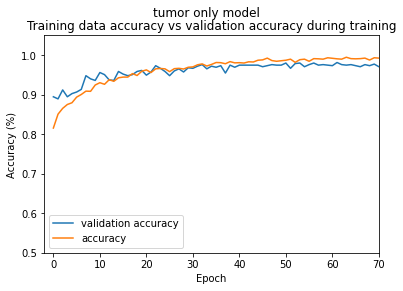

In [152]:
plt.plot(binary_history.history['val_accuracy'], label="validation accuracy")
plt.plot(binary_history.history['accuracy'], label="accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.suptitle('tumor only model')
plt.title('Training data accuracy vs validation accuracy during training')
ax = plt.gca()
ax.set_xlim([-2, 70])
ax.set_ylim([0.5, 1.05])
plt.legend()
plt.show()

In [174]:
mc_data = []
mc_result = []

mc_encoder = OneHotEncoder()
mc_encoder.fit([[0], [1], [2]])  # 0 = no tumor, 1 = meningioma tumor, 2 = glioma tumor , 3 = pitulitary tumor

# path to meningioma files
meningioma_image_dir = "dataset/split_data/multi-class/meningioma_tumor"
meningioma_files = os.listdir(meningioma_image_dir)

# path to glioma files
glioma_image_dir = "dataset/split_data/multi-class/glioma_tumor"
glioma_files = os.listdir(glioma_image_dir)

# path to pitulitary files
pitulitary_image_dir = "dataset/split_data/multi-class/pitulitary_tumor"
pitulitary_files = os.listdir(pitulitary_image_dir)


print("lengths of the tumors files")
print("length of meningioma tumor files " + str(len(meningioma_files)))
print("length of glioma tumor files " + str(len(glioma_files)))
print("length of pitulitary tumor files " + str(len(pitulitary_files)))
print("total files is " + str(len(meningioma_files)+len(glioma_files)+len(pitulitary_files)))
# should be 3000 files in total


# could be looped to reduce amount of code

## Meningioma tumor ## 
for file in meningioma_files:
    temp_file_path = meningioma_image_dir + "/" + file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    mc_data.append(np.array(img))
    mc_result.append(mc_encoder.transform([[0]]).toarray())
       
## Glioma tumor ##
for file in glioma_files:
    temp_file_path = glioma_image_dir + "/"  +file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    mc_data.append(np.array(img))
    mc_result.append(mc_encoder.transform([[1]]).toarray())
        
## Pitulitary tumor ##     
for file in pitulitary_files:
    temp_file_path = pitulitary_image_dir + "/"  +file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    mc_data.append(np.array(img))
    mc_result.append(mc_encoder.transform([[2]]).toarray())
    
mc_data = np.array(mc_data)
mc_result = np.array(mc_result)
mc_result = mc_result.reshape(2546,3)
x_train,x_test,y_train,y_test = train_test_split(mc_data, mc_result, test_size=0.1, shuffle=True, random_state=0)

lengths of the tumors files
length of meningioma tumor files 855
length of glioma tumor files 860
length of pitulitary tumor files 831
total files is 2546


In [183]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

mc_model = Sequential()

mc_model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(32, 32, 1), padding = 'Same'))
mc_model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


mc_model.add(BatchNormalization())
mc_model.add(MaxPooling2D(pool_size=(2, 2)))
mc_model.add(Dropout(0.25))

mc_model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
mc_model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

mc_model.add(BatchNormalization())
mc_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
mc_model.add(Dropout(0.25))

mc_model.add(Flatten())

mc_model.add(Dense(512, activation='relu'))
mc_model.add(Dropout(0.5))
mc_model.add(Dense(3, activation='softmax'))

mc_model.compile(loss = "categorical_crossentropy", optimizer='Adamax',  metrics = ['accuracy'])
#print(model.summary())

start_time = time.time()
mc_history = mc_model.fit(x_train, y_train, epochs = 300, batch_size = 4, verbose=1, validation_data = (x_test, y_test), callbacks=[callback])
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/300
573/573 [==============================] - 7s 11ms/step - loss: 1.6085 - accuracy: 0.5980 - val_loss: 0.5150 - val_accuracy: 0.7608
Epoch 2/300
573/573 [==============================] - 6s 11ms/step - loss: 0.7072 - accuracy: 0.6975 - val_loss: 0.4777 - val_accuracy: 0.8000
Epoch 3/300
573/573 [==============================] - 6s 11ms/step - loss: 0.6261 - accuracy: 0.7254 - val_loss: 0.4581 - val_accuracy: 0.8000
Epoch 4/300
573/573 [==============================] - 6s 11ms/step - loss: 0.5550 - accuracy: 0.7621 - val_loss: 0.4551 - val_accuracy: 0.8000: 0.5931 - accu - ETA: 3s - - ETA: 2s - loss: 0.5
Epoch 5/300
573/573 [==============================] - 6s 11ms/step - loss: 0.4960 - accuracy: 0.7909 - val_loss: 0.4392 - val_accuracy: 0.7882
Epoch 6/300
573/573 [==============================] - 6s 11ms/step - loss: 0.4599 - accuracy: 0.8141 - val_loss: 0.3077 - val_accuracy: 0.8392
Epoch 7/300
573/573 [==============================] - 6s 11ms/step - loss: 0.4155 - ac

Epoch 56/300
573/573 [==============================] - 6s 11ms/step - loss: 0.0226 - accuracy: 0.9908 - val_loss: 0.1288 - val_accuracy: 0.9569
Epoch 57/300
573/573 [==============================] - 6s 11ms/step - loss: 0.0242 - accuracy: 0.9913 - val_loss: 0.1035 - val_accuracy: 0.9569
Epoch 58/300
573/573 [==============================] - 6s 11ms/step - loss: 0.0229 - accuracy: 0.9921 - val_loss: 0.1038 - val_accuracy: 0.9608
Epoch 59/300
573/573 [==============================] - 6s 11ms/step - loss: 0.0310 - accuracy: 0.9869 - val_loss: 0.1172 - val_accuracy: 0.9686
Epoch 60/300
573/573 [==============================] - 6s 11ms/step - loss: 0.0236 - accuracy: 0.9921 - val_loss: 0.1322 - val_accuracy: 0.9608
Epoch 61/300
573/573 [==============================] - 6s 11ms/step - loss: 0.0175 - accuracy: 0.9939 - val_loss: 0.0787 - val_accuracy: 0.9725
Epoch 62/300
573/573 [==============================] - 6s 11ms/step - loss: 0.0228 - accuracy: 0.9935 - val_loss: 0.0788 - val_ac

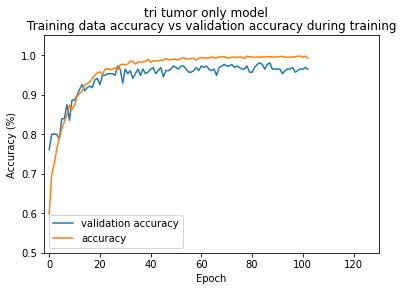

In [184]:
plt.plot(mc_history.history['val_accuracy'], label="validation accuracy")
plt.plot(mc_history.history['accuracy'], label="accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.suptitle('tri tumor only model')
plt.title('Training data accuracy vs validation accuracy during training')
ax = plt.gca()
ax.set_xlim([-2, 130])
ax.set_ylim([0.5, 1.05])
plt.legend()
plt.show()

In [185]:
validation_data = []
validation_result = []

validation_encoder = OneHotEncoder()
validation_encoder.fit([[0], [1], [2], [3]]) 

# path to non tumor files
no_tumor_image_dir = "test_dataset/test/split_data/multi-class/no_tumor"
no_tumor_files = os.listdir(no_tumor_image_dir)

# path to meningioma files
meningioma_image_dir = "test_dataset/test/split_data/multi-class/meningioma_tumor"
meningioma_files = os.listdir(meningioma_image_dir)

# path to glioma files
glioma_image_dir = "test_dataset/test/split_data/multi-class/glioma_tumor"
glioma_files = os.listdir(glioma_image_dir)

# path to pitulitary files
pitulitary_image_dir = "test_dataset/test/split_data/multi-class/pitulitary_tumor"
pitulitary_files = os.listdir(pitulitary_image_dir)


for file in no_tumor_files:
    temp_file_path = no_tumor_image_dir + "/" +file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    validation_data.append(np.array(img))
    validation_result.append(validation_encoder.transform([[0]]).toarray())

for file in meningioma_files:
    temp_file_path = meningioma_image_dir + "/" + file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    validation_data.append(np.array(img))
    validation_result.append(validation_encoder.transform([[1]]).toarray())
        
for file in glioma_files:
    temp_file_path = glioma_image_dir + "/"  +file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    validation_data.append(np.array(img))
    validation_result.append(validation_encoder.transform([[2]]).toarray())
        
        
for file in pitulitary_files:
    temp_file_path = pitulitary_image_dir + "/"  +file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    validation_data.append(np.array(img))
    validation_result.append(validation_encoder.transform([[3]]).toarray())
     
        
validation_data = np.array(validation_data)
validation_result = np.array(validation_result)
validation_result = validation_result.reshape(200,4)

In [186]:
def ensemble_predict(img):
    binary_result = binary_model.predict(img)
    if binary_result[0].argmax() == 0:
        return(0)
    else:
        mc_result = mc_model.predict(img)
        return(mc_result[0].argmax()+1)
        

In [187]:
def get_tumor_name(num):
        if num == 0:
            return("no tumor")
        if num == 1:
            return("meningioma")
        if num == 2:
            return("glioma")
        if num == 3:
            return("pitulitary")

In [194]:
# 0 - no tumor
# 1 - meningioma
# 2 - glioma
# 3 - pitulitary
difficult_images = []

count = 0 
for i in range(len(validation_result)):
    img = np.expand_dims(validation_data[i], axis = 0)
    if (get_tumor_name(ensemble_predict(img))==get_tumor_name(validation_result[i].argmax())):
        #print("match")
        count=count+1
    else:
        difficult_images.append(i)
        print("predicted : " + get_tumor_name(ensemble_predict(img)) + ". actual : " + get_tumor_name(validation_result[i].argmax()))
    #print("---")

predicted : meningioma. actual : no tumor
predicted : no tumor. actual : meningioma
predicted : pitulitary. actual : meningioma
predicted : pitulitary. actual : meningioma
predicted : pitulitary. actual : meningioma
predicted : pitulitary. actual : meningioma
predicted : meningioma. actual : glioma
predicted : meningioma. actual : glioma
predicted : meningioma. actual : glioma
predicted : no tumor. actual : glioma


In [198]:
difficult_images

[17, 39, 54, 58, 74, 97, 107, 110, 111, 120]

In [189]:
count/len(validation_result)

0.95

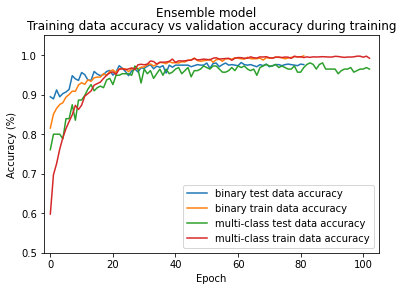

In [197]:
plt.plot(binary_history.history['val_accuracy'], label="binary test data accuracy")
plt.plot(binary_history.history['accuracy'], label="binary train data accuracy")
plt.plot(mc_history.history['val_accuracy'], label="multi-class test data accuracy")
plt.plot(mc_history.history['accuracy'], label="multi-class train data accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.suptitle('Ensemble model')
plt.title('Training data accuracy vs validation accuracy during training')
ax = plt.gca()
ax.set_xlim([-2, 105])
ax.set_ylim([0.5, 1.05])
plt.legend()
plt.show()